# Texas Districting

This notebook explores Texas political districting.

Texas has awesome public data from the Texas Legislative Council. I don't think it's this easy for every state.

In [206]:
from ftplib import FTP
ftp = FTP('ftpgis1.tlc.state.tx.us')
ftp.login()

#ftp.cwd('elections')
# this is a big file
# ftp.retrbinary('RETR 2016_General_Election_Returns.csv', open('returns.csv', 'wb').write)
# ftp.retrbinary('RETR 2016_General_Election_VRTO.csv', open('vrto.csv', 'wb').write)
#ftp.cwd('VTDs')
#ftp.cwd('Geography')
#ftp.retrbinary('RETR ReadMe.txt', open('ReadMe.txt', 'wb').write)
# this is a big file
# ftp.retrbinary('RETR VTDs.zip', open('VTDs.zip', 'wb').write)
ftp.retrlines('LIST')


02-18-11  06:50PM               405305 BlockGroupsPop.zip
02-20-11  04:12PM              9369416 BlocksPop.zip
02-18-11  06:30PM                 8546 CountiesPop.zip
02-20-11  05:11PM                 5500 readme.txt
02-18-11  06:17PM               153284 TractsPop.zip


'226 Transfer complete.'

I'm still figuring out how to use pandas effectively. Here we are trying to process the data from the CSV file and build lookup dicts for the number of voters for Trump vs Hilary.

In [6]:
import pandas as pd

In [7]:
d = pd.read_csv('returns.csv')

In [8]:
d.head()

,County,FIPS,VTD,cntyvtd,Office,Name,Party,Incumbent,Votes
0,Anderson,1,0001,10001,President,Clinton,D,N,262
1,Anderson,1,0002,10002,President,Clinton,D,N,181
2,Anderson,1,0003,10003,President,Clinton,D,N,94
3,Anderson,1,0004,10004,President,Clinton,D,N,96
4,Anderson,1,0005,10005,President,Clinton,D,N,9


In [95]:
clintons = d[d['Name'].str.contains('Clinton')]
trumps = d[d['Name'].str.contains('Trump')]

In [111]:
trump_lookup = {}
for r in trumps.iterrows():
    trump_lookup[r[1]['cntyvtd']] = r[1]['Votes']
clinton_lookup = {}
for r in clintons.iterrows():
    clinton_lookup[r[1]['cntyvtd']] = r[1]['Votes']

Now that we have the data, let's try to merge it into our shape data. We are adding three more columns, "trump", "clinton", and "ratio". "ratio" is supposed to mean how much of the VTD voted for Clinton out of all votes for Clinton and Trump. 1.0 means that there were zero Trump votes and at least one Clinton vote. 0.0 means that there were zero Clinton votes and at least one Trump vote. I wasn't sure what to do if there were zero for both candidates, so I split the difference and assigned it 0.5

In [131]:
total_lookup = {}
for k,v in clinton_lookup.items():
    t = trump_lookup[k]
    if v+t==0:
        total = 0.5
    else:
        total = v/(v+t)
    total_lookup[k] = total

In [209]:
vrto = pd.read_csv('vrto.csv')
vrto.head()

,County,FIPS,VTD,CNTYVTD,TotalPop,TotalVR,SpanishSurnamePercent,TotalTO
0,Anderson,1,0001,10001,3131,1799,7.2,1030
1,Anderson,1,0002,10002,3744,2455,3.9,1532
2,Anderson,1,0003,10003,1766,1195,4.4,776
3,Anderson,1,0004,10004,2147,1525,2.6,985
4,Anderson,1,0005,10005,476,282,2.5,191


In [224]:
spanish_percent = {}
total_pop = {}
for r in vrto.iterrows():
    cntyvtd = r[1]['CNTYVTD']
    v_percent = r[1]['SpanishSurnamePercent']
    pop = r[1]['TotalPop']
    spanish_percent[cntyvtd] = v_percent
    total_pop[cntyvtd] = pop

In [200]:
import geopandas as gpd

In [133]:
shape=gpd.read_file('VTDs/VTDs.shp')

In [134]:
shape['coords'] = shape['geometry'].apply(lambda x: x.representative_point().coords[:])
shape['coords'] = [coords[0] for coords in shape['coords']]

In [244]:
density_lookup = {}
max_density = 0
for r in shape.iterrows():
    cntyvtd = r[1]['CNTYVTD']
    area = r[1]['Shape_area']
    density_lookup[cntyvtd] = total_pop[cntyvtd]/area
    max_density = max(total_pop[cntyvtd]/area, max_density)
max_density

0.035341561988706575

In [268]:
shape['trump'] = shape['CNTYVTD'].apply(lambda x: trump_lookup[x])
shape['clinton'] = shape['CNTYVTD'].apply(lambda x: clinton_lookup[x])
shape['ratio'] = shape['CNTYVTD'].apply(lambda x: total_lookup[x])
shape['spanish'] = shape['CNTYVTD'].apply(lambda x: spanish_percent[x])
shape['pop_density'] = shape['CNTYVTD'].apply(lambda x: density_lookup[x])
shape['pres_votes'] = shape['CNTYVTD'].apply(lambda x: clinton_lookup[x] - trump_lookup[x])

In [269]:
shape.head(2)

,CNTY,COLOR,VTD,CNTYVTD,VTDKEY,Shape_area,Shape_len,e_ang,e_oth,e_hsp,...,geometry,coords,trump,clinton,ratio,NEIGHBORS,spanish,pop,pop_density,pres_votes
0,53,2,0008,530008,1221,6.717692e+07,55772.006345,1117,19,131,...,"POLYGON ((1159123.584899999 956882.9655999988,...","(1156952.144897459, 950869.3875500001)",611,127,0.172087,"530001, 530007, 530009, 2990203, 2990307",5.9,1269,0.000019,-484
1,469,2,0024,4690024,8511,5.426296e+07,50831.107001,1357,8,276,...,"POLYGON ((1292779.280299999 755618.5639000013,...","(1287538.1095648122, 751569.2849500012)",845,107,0.112395,"4690011, 4690003, 4690023, 4690021, 4690033, 4...",14.8,1679,0.000031,-738


# Trump v Clinton Ratio
Now we can visualize the data geographically. We will use map Trump voting VTD's as red and Clinton voting VTD's and blue. It looks like one's in the middle (and zeros) turn out white. Immediately, we can see that voters in major cities like Houston, Dallas, Austin, and San Antonio were more likely to vote for Clinton. It's also clear that in many rural areas close to the border (but not all), voters were more likely to vote for Clinton.

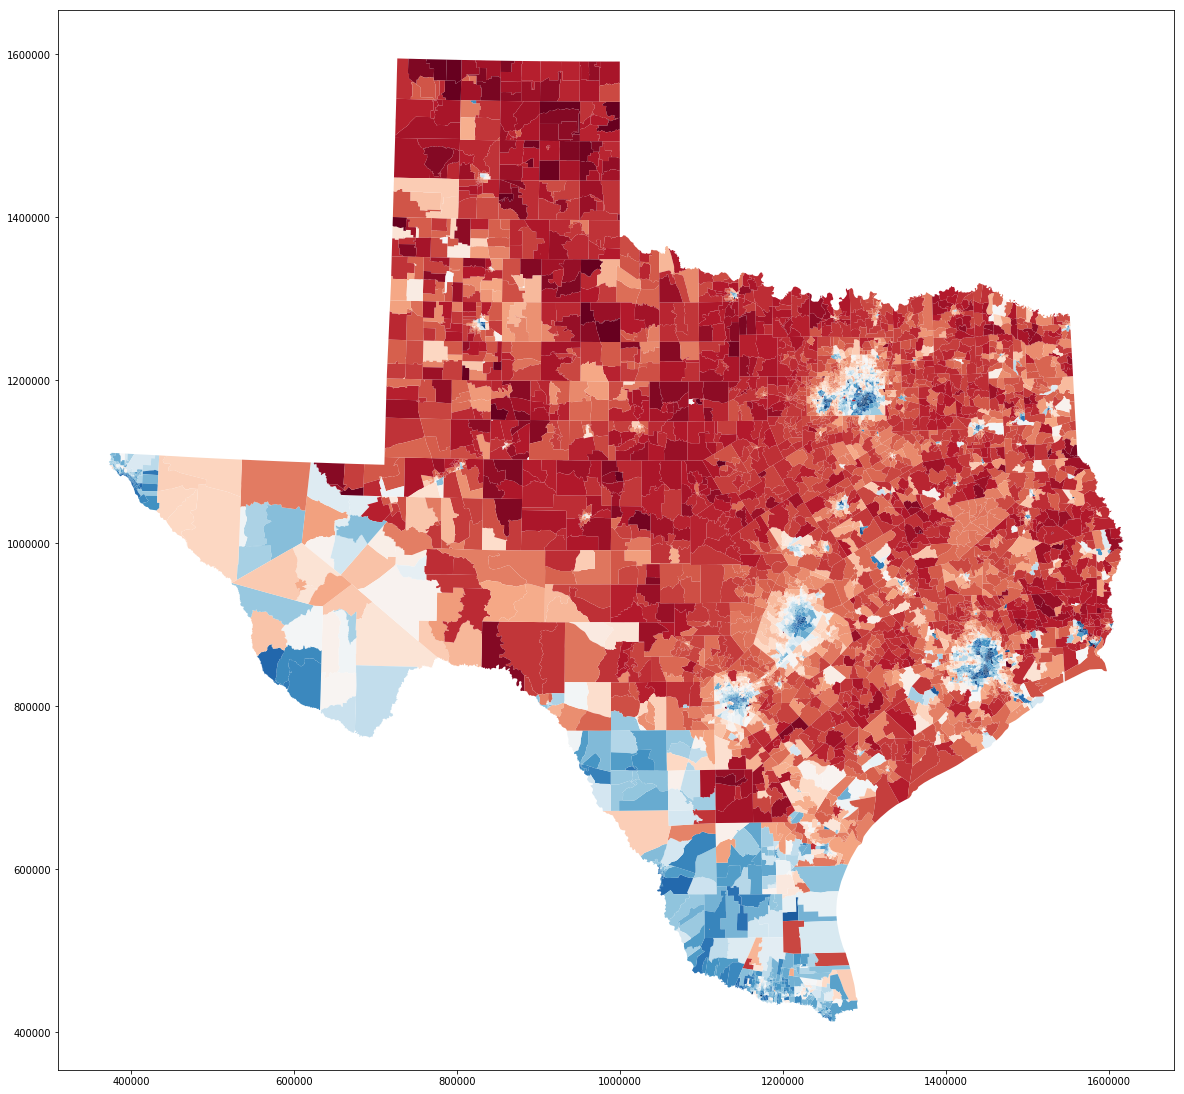

In [137]:
shape.plot(column='ratio', figsize=(20,20), cmap='RdBu')

# Vote Difference
This looks like a more accurate way to present the data, because it doesn't visually overrepresent low-population density areas. It looks like the mid-sized towns in Texas were Trump took huge leads. While Clinton picked up the most votes in the Texas triangle cities.

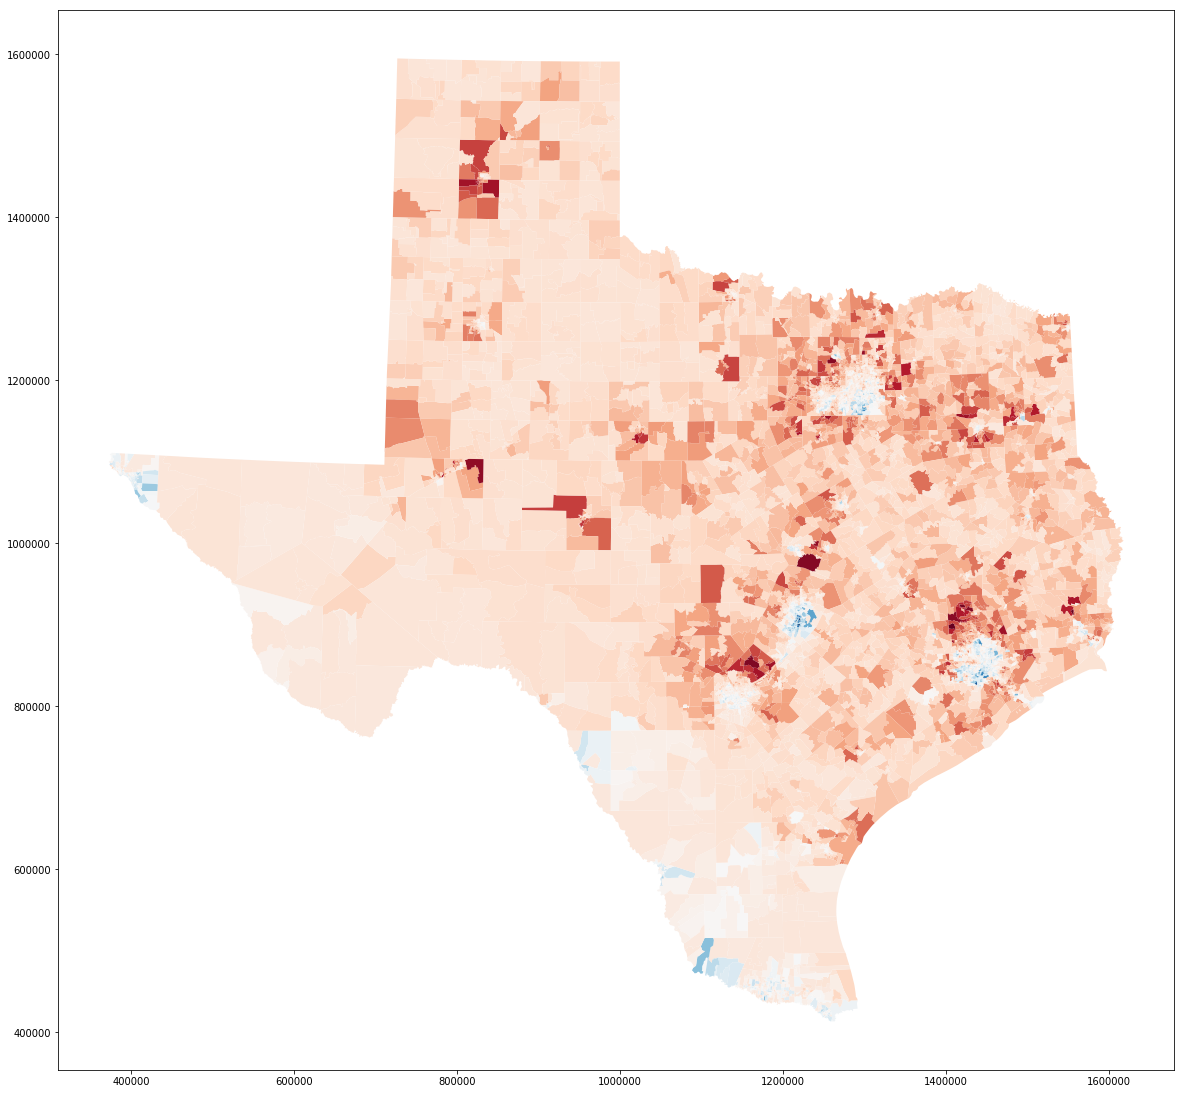

In [270]:
shape.plot(column='pres_votes', figsize=(20,20), cmap='RdBu')

# Spanish Surnames
Now let's look at Spanish surname percentages. Unsurprisingly, it looks areas low percentages of Trump voters had high percentages of Spanish surnames. This also seems to show that some of the rural border areas that voted for Trump seemed to have very low Spanish surnamed voters.

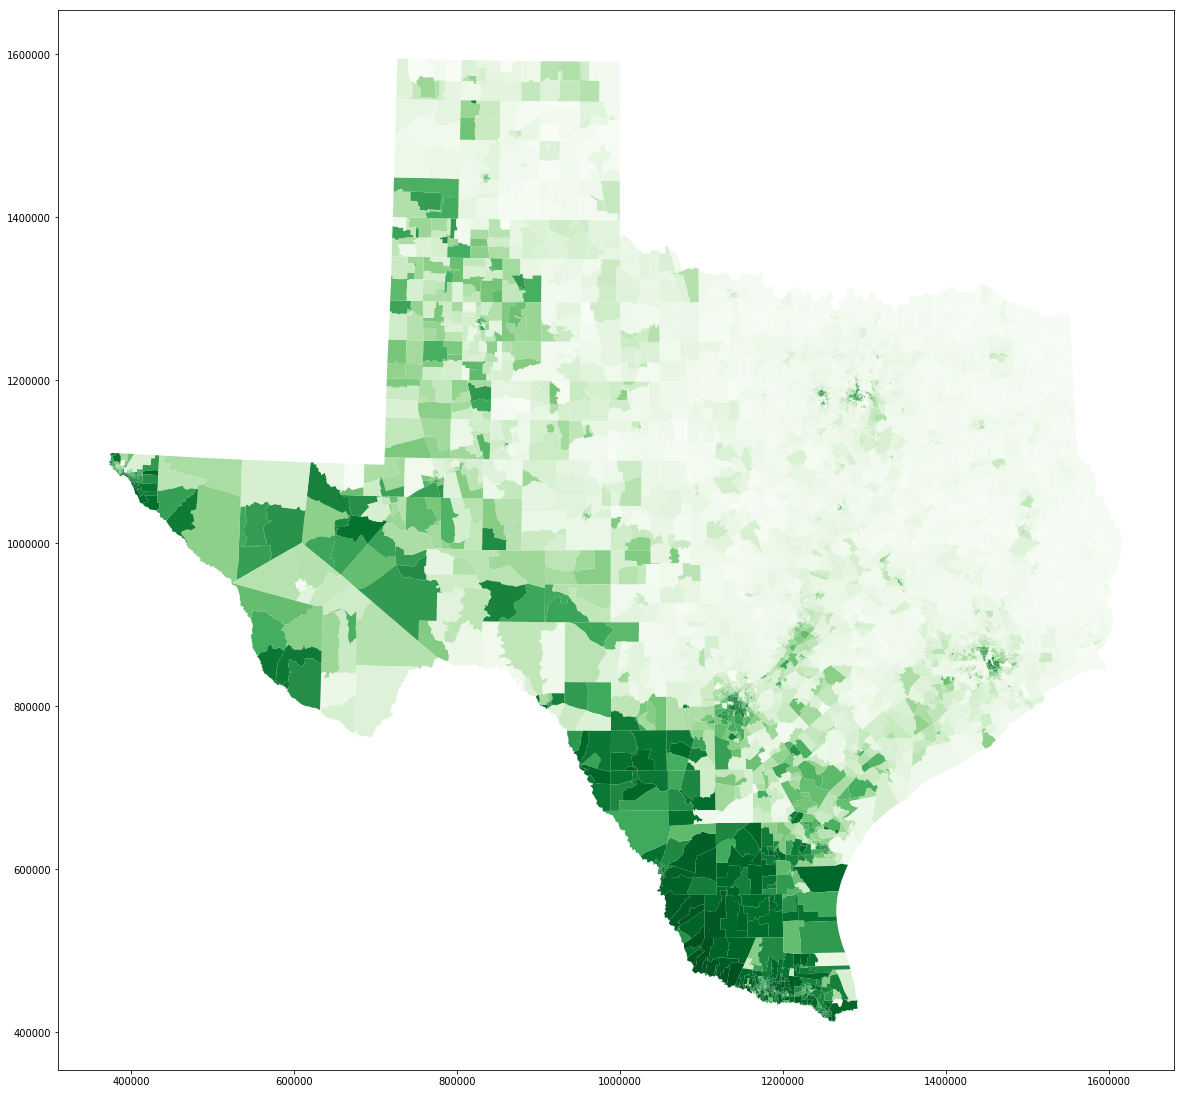

In [265]:
shape.plot(column='spanish', figsize=(20,20), cmap='Greens')

# Population Density
This shows where the major population areas of Texas are. You can see the big cities pretty clearly again.


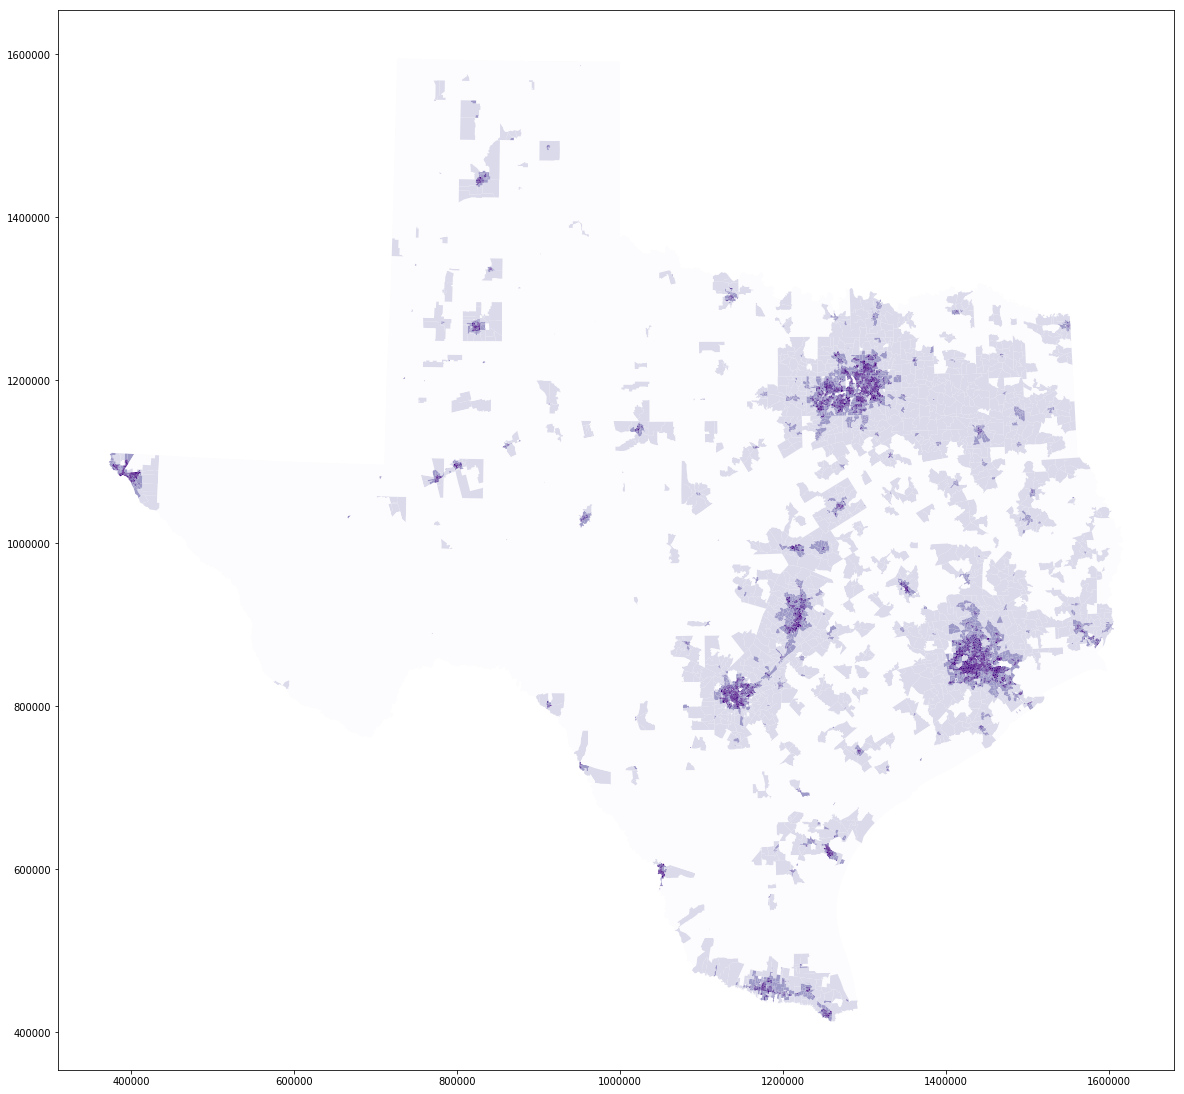

In [266]:
shape.plot(column='pop_density', figsize=(20,20), cmap='Purples', scheme='quantiles')

Congressional districts are required to be contiguous, so we're going to be interested in which VTD's border each other. So here we try to find all of the VTD neighbors. This algorithm is expensive but we only need to run it once.

In [148]:
from tqdm import tqdm_notebook
shape["NEIGHBORS"] = None  # add NEIGHBORS column

# This takes a really long time
for index, country in tqdm_notebook(shape.iterrows()):   
    # get 'not disjoint' countries
    neighbors = shape[~shape.geometry.disjoint(country.geometry)].CNTYVTD.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if country.CNTYVTD != name ]
    # add names of neighbors as NEIGHBORS value
    shape.at[index, "NEIGHBORS"] = ", ".join(neighbors)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

To see some examples of whether our neighbor algorithm work, let's take a small subset of our data at the very top of Texas.

In [201]:
top = shape.cx[:,1500000:]
top.head(1)

,CNTY,COLOR,VTD,CNTYVTD,VTDKEY,Shape_area,Shape_len,e_ang,e_oth,e_hsp,...,e_hspvap,e_bhvap,e_blakvap,e_othvap,geometry,coords,trump,clinton,ratio,NEIGHBORS
2,421,6,0302,4210302,7203,4.890835e+08,115435.448089,372,10,125,...,86,87,1,5,"POLYGON ((835910.170599997 1592476.453899998, ...","(845032.6457607909, 1580476.1839500014)",126,11,0.080292,"4210202, 4210301, 4210401, 1950003, 1950007"


Then let's get a dataframe of the first VTD in our subset(4210302), and find his neighbors as well as himself.

In [197]:
neighbor_ids = top.head(1).NEIGHBORS.item().split(', ')
neighbor_ids.append(top.head(1).CNTYVTD.item())
neighbors = top[top['CNTYVTD'].apply(lambda x: x in neighbor_ids)]

Now let's plot it in gray, and then plot the neighbors on top in yellow.

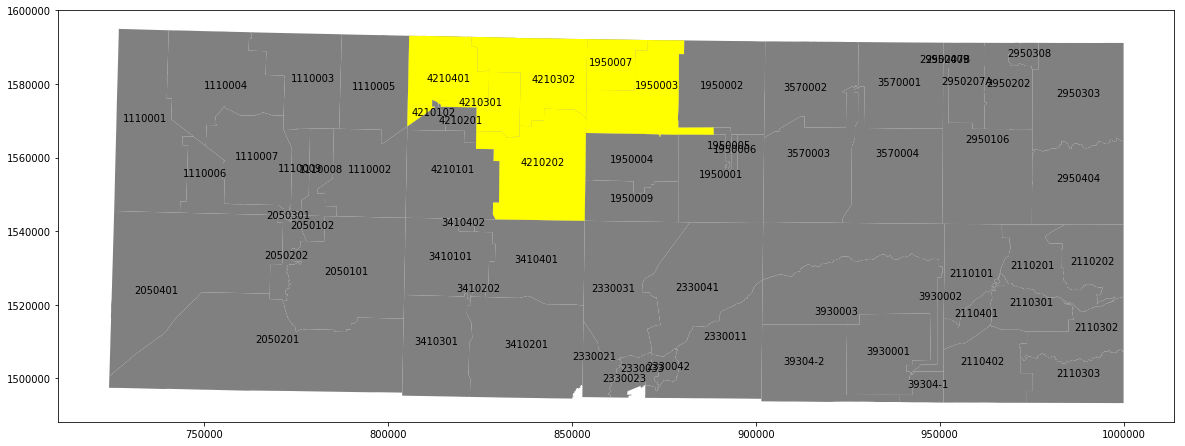

In [198]:

x = top.plot(figsize=(20,20), facecolor='gray')
for idx, row in top.iterrows():
    plt.annotate(s=row['CNTYVTD'], xy=row['coords'],
                 horizontalalignment='center')
neighbors.plot(ax=x.axes, figsize=(30,30), facecolor='yellow')

